In [ ]:
##Please first install the following packgage in ur local environment:
# pip install tensorflow-gpu, opencv-python, numpy, Pillow, scipy
#Mount ur google drive, there will be a url for an authorization code
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#Upload the Dataset to ur google drive and unzip it.
!nohup unzip /gdrive/'My Drive'/'Colab Notebooks'/Datali.zip      
!ls

nohup: ignoring input and appending output to 'nohup.out'
Datali	__MACOSX  nohup.out  sample_data


In [ ]:
# Please install below:
# !conda install pytorch torchvision torchaudio -c pytorch -c conda-forge
# pip install matplotlib

In [ ]:
# Import libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# Parameters
batch_size = 128
vali_split = 0.3
learning_rate = 0.00001
epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NameError: ignored

In [ ]:
# First method, the most general one
class MyVGG(torch.nn.Module):
  # put your models here
  def __init__(self):
    super().__init__()
    self.vgg19_features = models.vgg19(pretrained=False).features
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(128*64, 512)
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.25)
    self.fc2 = torch.nn.Linear(512, 512)
    self.relu2 = torch.nn.ReLU()
    self.dropout2 = torch.nn.Dropout(p=0.25)
    self.fc3 = torch.nn.Linear(512, 3)
    self.softmax = torch.nn.Softmax(dim=1)
    
  # define inference
  def forward(self,x):
    x = self.vgg19_features(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)
    x = self.fc3(x)
    x = self.softmax(x)

    return x

In [ ]:
# Transform is used to preprocess your raw image data and convert to tensors
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             ])}
# loading images using datasets function
# This will automatically label the subdirectories! 
dataset = torchvision.datasets.ImageFolder(root='Datali', transform=transform_dict['train'])
# Split the datasets for training and validation
# traing_size + val_size should equal the number of the total images
train_size = (int) (len(dataset) * vali_split)
val_size = len(dataset) - train_size
dataset_sizes = {'train': train_size, 'val': val_size}
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [train_size, val_size])
# create dataloader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

image shape ==>; torch.Size([3, 256, 256])
Label is  1


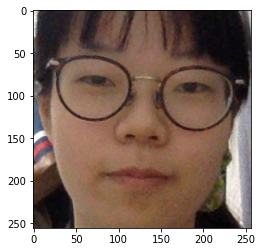

In [ ]:
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_loader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].data.numpy())

In [ ]:
# Training algorithm
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('best model saved')


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = MyVGG().to(device)
# Set loss function
criterion = torch.nn.CrossEntropyLoss()
# Set optimizer 
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-9)
best_model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)

KeyboardInterrupt: ignored

In [ ]:
# Save the model
torch.save(model, 'bevgg5_model.h5')

In [ ]:
# Load model
loaded_model = torch.load('bevgg5_model.h5', map_location=torch.device('cpu')) # for cpu
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_loader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].data.numpy())
img_s=pic
trans = transforms.ToTensor()#np.rollaxis(img,2,0)
img_s = trans(img_s)
output = loaded_model(img_s[np.newaxis, :, :] )
print(output[0])
_, pred = torch.max(output, 1)
if pred==0:
  print("no glasses")
if pred==1:
  print("round glasses")
if pred==2:
  print("skuea glasses")

In [ ]:
class MyRes34(torch.nn.Module):
  # put your models here
  def __init__(self):
    super().__init__()
    self.res34 = torch.nn.Sequential(*list(models.resnet34(pretrained=True).children())[:-2])
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(128*64, 512)
    self.relu1 = torch.nn.ReLU()
    self.dropout1 = torch.nn.Dropout(p=0.25)
    self.fc2 = torch.nn.Linear(512, 512)
    self.relu2 = torch.nn.ReLU()
    self.dropout2 = torch.nn.Dropout(p=0.25)
    self.fc3 = torch.nn.Linear(512, 3)
    self.softmax = torch.nn.Softmax(dim=1)
    
  # define inference
  def forward(self,x):
    x = self.res34(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)
    x = self.fc3(x)
    x = self.softmax(x)
#     x = self.relu(x)

    return x

In [ ]:
# candidate_model = MyRes50().to(device)
model = MyRes34().to(device)
criterion = torch.nn.CrossEntropyLoss()
# Set optimizer 
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-9)
best_model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)

In [ ]:
# Save the model
torch.save(model, 'beres4_model.h5')

In [ ]:
print(model)

In [ ]:
# How to load and test model
import torch

# Input   ここを自分の画像で実装してください。
#openCVがおすすめ
#入力の形に合わせる
inp = torch.from_numpy(np.random.rand(1, 3, 32, 32)).float()

# Load model
loaded_model = torch.load('beres4_model.h5', map_location=torch.device('cpu')) # for cpu

# Predict
output = loaded_model(inp)

# Output ここを犬か猫か判別してください。
print(output)
print(output[0])

In [ ]:
import cv2
import numpy as np

In [ ]:
# Load an color image in grayscale
img = cv2.imread('/gdrive/My Drive/Colab Notebooks/keroppi.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# import module
from matplotlib import pyplot as plt
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
img = cv2.resize(img, dsize=(32, 32))
trans = transforms.ToTensor()#np.rollaxis(img,2,0)
img_2 = trans(img)
img_2 = img_2[np.newaxis, :, :] #img.reshape(1,3,32,32)
# loading images using datasets function
# This will automatically label the subdirectories! 

In [ ]:
# Load model
loaded_model = torch.load('beres4_model.h5', map_location=torch.device('cpu')) # for cpu
# Predict
output = loaded_model(img_2)
_, pred = torch.max(output, 1)
# Output ここを犬か猫か判別してください。
if pred==0:
  print("no glasses")
if pred==1:
  print("round glasses")
if pred==2:
  print("skuea glasses")
if pred==3:
  print("yubi")

In [ ]:
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_loader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].data.numpy())

In [ ]:
img_s=pic
img_s = trans(img_s)
output = loaded_model(img_s[np.newaxis, :, :] )
print(output[0])
_, pred = torch.max(output, 1)
if pred==0:
  print("no glasses")
if pred==1:
  print("round glasses")
if pred==2:
  print("skuea glasses")
if pred==3:
  print("yubi")

In [ ]:
#書き込み情報の設定
pt1 = (50,50)
pt2 = (200,50)
color = (255,0,0)
fontcolor = (0,0,255)
width = 5
fontsize = 0.7
fontwidth = 2
r = 10
fontface = cv2.FONT_HERSHEY_SIMPLEX#フォント種類

In [ ]:

from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture('test.mov')

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        img = cv2.resize(frame, dsize=(32, 32))
        trans = transforms.ToTensor()#np.rollaxis(img,2,0)
        img = trans(img)
        img = img[np.newaxis, :, :] 
        output = loaded_model(img)
        _, pred = torch.max(output, 1)
        if pred==0:
          cv2.putText(frame,'cat',pt1,fontface,fontsize,fontcolor,fontwidth)
        if pred==1:
          cv2.putText(frame,'dog',pt1,fontface,fontsize,fontcolor,fontwidth)
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
class MyRes50(torch.nn.Module):
  # put your models here
  def __init__(self):
    super().__init__()
    self.res50 = torch.nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(2048*7*7, 4096)
    self.relu1 = torch.nn.ReLU()
    self.dropout1 = torch.nn.Dropout(p=0.25)
    self.fc2 = torch.nn.Linear(4096, 4096)
    self.relu2 = torch.nn.ReLU()
    self.dropout2 = torch.nn.Dropout(p=0.25)
    self.fc3 = torch.nn.Linear(4096, 4)
    self.fc3.weight.data.fill_(0.0)
    
  # define inference
  def forward(self,x):
    x = self.res50(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)
    x = self.fc3(x)
#     x = self.relu(x)

    return x

In [ ]:
# candidate_model = MyRes50().to(device)
model = MyRes50().to(device)
criterion = torch.nn.CrossEntropyLoss()
# Set optimizer 
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-9)
best_model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)

Epoch 0/9
----------


RuntimeError: ignored